# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [29]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [31]:
import os
os.getcwd()

'/data/ephemeral/home/code'

In [174]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '../data/train.csv'
test_path  = '../data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [175]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [176]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [177]:
# 주소로 unique id를 만들어봅니다

concat['본번'] = concat['본번'].fillna(-1)
concat['부번'] = concat['부번'].fillna(-1)

concat['본번'] = concat['본번'].astype(int).astype(str).replace({-1: np.nan})
concat['부번'] = concat['부번'].astype(int).astype(str).replace({-1: np.nan})

concat['지번_temp'] = concat['본번'] + '-' + concat['부번']

concat['번지'] = concat['번지'].fillna(concat['지번_temp'])
concat['번지'].isnull().sum()

concat = concat.drop('지번_temp', axis=1)

0

In [178]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat['본번'] = concat['본번'].astype('str')
concat['부번'] = concat['부번'].astype('str')


# '시군구'와 '번지'를 이용해 unique id를 만들어준다
concat['주소'] = concat['시군구'] + ' ' + concat['번지']

### xy좌표 결측치를 제거해봅니다

In [179]:
# xy좌표를 불러오고 unique id를 맞춰준다

coordinates = pd.read_csv('../data/xy좌표.csv', encoding='cp949')

coordinates['주소'] = coordinates['시군구'] + ' ' + coordinates['번지']

In [180]:
concat_temp = pd.merge(concat, coordinates, on='주소', how='left', suffixes=('_A', '_B'))

concat = concat_temp

concat = concat.drop(columns=['시군구_B', '번지_B'])

concat = concat.rename(columns={'시군구_A':'시군구'})
concat = concat.rename(columns={'번지_A':'번지'})

### xy좌표 결측치 채우기(주소로 정렬한 후 선형보간으로 채우기)

In [182]:
# xy좌표 결측치 채우기(주소로 정렬한 후 선형보간으로 채우기)

concat_sorted = concat.sort_values(by='주소')

# 연속형 변수에 대한 보간 (선형 보간)
col = ['x', 'y']
concat_sorted[col] = concat_sorted[col].interpolate(method='linear', axis=0)

concat = concat_sorted.sort_index()

In [183]:
concat['계약년월'] = concat['계약년월'].astype(str)

concat['계약년'] = concat['계약년월'].str[:4]
concat['계약월'] = concat['계약년월'].str[4:]

concat['계약년'] = concat['계약년'].astype(int)
concat['계약월'] = concat['계약월'].astype(int)

In [184]:
# 해제사유발생 = 1, 미발생 = 0 으로 바꾸기

concat['거래취소여부'] = concat['해제사유발생일'].notnull().astype(int)

concat['거래취소여부'].value_counts()

concat = concat.drop(columns = '해제사유발생일',  errors='ignore')

In [187]:
# 불필요한 컬럼 제거

drop_columns = ['아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지', '좌표X', '좌표Y','계약년월'
                'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-관리방식', 'k-난방방식', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
                'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', '단지승인일',
                'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '관리비 업로드', '단지신청일'
                ]

concat = concat.drop(columns = drop_columns,  errors='ignore')

In [188]:
# 거래일 건물연식

concat['거래일건물연식'] = concat['계약년'] - concat['건축년도']

In [189]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat['구'] = concat['시군구'].map(lambda x : x.split()[1])
concat['동'] = concat['시군구'].map(lambda x : x.split()[2])
del concat['시군구']

# concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
# concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat['계약년월']

In [191]:
all = list(concat['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat['강남여부'] = is_gangnam

In [192]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
# 노후건축물 기준에 맞추어 거래일 기준 20년 미만일 시 신축으로 분류
concat['신축여부'] = concat['거래일건물연식'].apply(lambda x: 1 if x < 20 else 0)

In [ ]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

# concat.columns

In [194]:
concat.to_csv('../data/base_dataset.csv', index=False)

### 기본 데이터셋 정의

In [148]:
# 위 코드까지 실행할 결과를 새로운 기본 데이터셋으로 삼음
concat = pd.read_csv('../data/base_dataset.csv')

drop_col = ['k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-복도유형', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', '건축면적', '주차대수']

concat = concat.drop(columns = drop_col, errors = 'ignore')

### 빈 데이터를 채움

In [149]:
# 지번별 건물정보가 담긴 gis건물통합정보 파일을 불러와 데이터 병합하기

gis = pd.read_csv('../data/gis건물통합정보.csv')

drop_col = ['Unnamed: 0', '법정동명', '번지', '사용승인일자']
gis = gis.drop(columns = drop_col)

gis = gis.rename(columns={'ID':'주소'})

gis= gis.groupby('주소', as_index=False).agg({'건축면적': 'sum', '연면적': 'sum', '대지면적': 'sum', '건폐율': 'sum', '용적율': 'sum'})

gis.head()

,주소,건축면적,연면적,대지면적,건폐율,용적율
0,서울특별시 강남구 개포동 1055,507.18,11729.79,3017.0,16.81,51.99
1,서울특별시 강남구 개포동 1057-9,608.80,1359.20,3062.0,19.88,39.76
2,서울특별시 강남구 개포동 108,0.00,0.00,0.0,0.00,0.00
3,서울특별시 강남구 개포동 109,0.00,0.00,0.0,0.00,0.00
4,서울특별시 강남구 개포동 112-1,0.00,0.00,0.0,0.00,0.00


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# IterativeImputer 사용 보간

concat_temp = pd.merge(concat, gis, on='주소', how='left', suffixes=('_A', '_B'))

concat_temp.sort_values('주소')

col = ['건축면적', '연면적', '대지면적', '건폐율', '용적율']
concat_temp[col] = concat_temp[col].replace(0, np.nan)

concat_temp[col] = concat_temp[col].interpolate(method='linear', axis=0)

concat_temp.sort_index()

concat_temp.isnull().sum()

In [150]:
concat_temp = pd.merge(concat, gis, on='주소', how='left', suffixes=('_A', '_B'))

concat_temp.sort_values('주소')

col = ['건축면적', '연면적', '대지면적', '건폐율', '용적율']
concat_temp[col] = concat_temp[col].replace(0, np.nan)

concat_temp[col] = concat_temp[col].interpolate(method='linear', axis=0).fillna(method='ffill')

concat_temp.sort_index()

,번지,본번,부번,전용면적,계약일,층,건축년도,target,is_test,주소,...,거래일건물연식,구,동,강남여부,신축여부,건축면적,연면적,대지면적,건폐율,용적율
0,658-1,658,1,79.97,8,3,1987,124000.0,0,서울특별시 강남구 개포동 658-1,...,30,강남구,개포동,1,0,4551.33,22305.93,NaN,NaN,NaN
1,658-1,658,1,79.97,22,4,1987,123500.0,0,서울특별시 강남구 개포동 658-1,...,30,강남구,개포동,1,0,4551.33,22305.93,NaN,NaN,NaN
2,658-1,658,1,54.98,28,5,1987,91500.0,0,서울특별시 강남구 개포동 658-1,...,30,강남구,개포동,1,0,4551.33,22305.93,NaN,NaN,NaN
3,658-1,658,1,79.97,3,4,1987,130000.0,0,서울특별시 강남구 개포동 658-1,...,31,강남구,개포동,1,0,4551.33,22305.93,NaN,NaN,NaN
4,658-1,658,1,79.97,8,2,1987,117000.0,0,서울특별시 강남구 개포동 658-1,...,31,강남구,개포동,1,0,4551.33,22305.93,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141115,816,816,0,84.65,19,13,2014,NaN,1,서울특별시 중랑구 신내동 816,...,9,중랑구,신내동,0,1,4576.42,7354.08,403098.3,228.47,4138.31
1141116,816,816,0,84.62,25,12,2014,NaN,1,서울특별시 중랑구 신내동 816,...,9,중랑구,신내동,0,1,4576.42,7354.08,403098.3,228.47,4138.31
1141117,816,816,0,101.65,27,12,2014,NaN,1,서울특별시 중랑구 신내동 816,...,9,중랑구,신내동,0,1,4576.42,7354.08,403098.3,228.47,4138.31
1141118,816,816,0,84.94,2,18,2014,NaN,1,서울특별시 중랑구 신내동 816,...,9,중랑구,신내동,0,1,4576.42,7354.08,403098.3,228.47,4138.31


In [151]:
a = ['대지면적', '건폐율', '용적율']
concat_temp = concat_temp.fillna(0)

In [152]:
concat_temp.isnull().sum()

번지         0
본번         0
부번         0
전용면적       0
계약일        0
층          0
건축년도       0
target     0
is_test    0
주소         0
x          0
y          0
계약년        0
계약월        0
거래취소여부     0
거래일건물연식    0
구          0
동          0
강남여부       0
신축여부       0
건축면적       0
연면적        0
대지면적       0
건폐율        0
용적율        0
dtype: int64

In [153]:
# 평균층수 파생변수
concat = concat_temp

concat['평균층수'] = concat['연면적'] / concat['건축면적'].replace(0, np.nan)

concat['평균층수'].isnull().sum()

0

In [154]:
concat['거래취소여부'].astype(str)
concat['강남여부'].astype(str)
concat['층'].astype(str)
concat['본번'].astype(str)
concat['부번'].astype(str)

0          1
1          1
2          1
3          1
4          1
          ..
1141115    0
1141116    0
1141117    0
1141118    0
1141119    0
Name: 부번, Length: 1141120, dtype: object

In [40]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat.columns:
    if pd.api.types.is_numeric_dtype(concat[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['본번', '부번', '전용면적', '계약일', '층', '건축년도', 'target', 'is_test', 'x', 'y', '계약년', '계약월', '거래취소여부', '거래일건물연식', '강남여부', '신축여부', '건축면적', '연면적', '대지면적', '건폐율', '용적율']
범주형 변수: ['번지', '주소', '구', '동']


In [155]:
continuous_columns = ['전용면적', '계약일', '건축년도', 'target', 'x', 'y', '계약년', '계약월', '거래일건물연식', '건축면적', '연면적', '대지면적', '건폐율', '용적율', '평균층수']
categorical_columns = ['번지', '주소', '구', '동', '본번', '부번', '층', 'is_test', '거래취소여부', '강남여부', '신축여부']

- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [138]:
# 범주형 변수에 대한 보간
concat[categorical_columns] = concat[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat[continuous_columns] = concat[continuous_columns].interpolate(method='linear', axis=0)

In [156]:
concat.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

번지         0
본번         0
부번         0
전용면적       0
계약일        0
층          0
건축년도       0
target     0
is_test    0
주소         0
x          0
y          0
계약년        0
계약월        0
거래취소여부     0
거래일건물연식    0
구          0
동          0
강남여부       0
신축여부       0
건축면적       0
연면적        0
대지면적       0
건폐율        0
용적율        0
평균층수       0
dtype: int64

In [85]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat.shape)

(1128094, 25)


In [ ]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [157]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [158]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat, '전용면적')

In [95]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

0    1041193
1       9390
Name: is_test, dtype: int64

In [65]:
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

,번지,본번,부번,전용면적,계약일,층,건축년도,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-복도유형,...,target,is_test,계약년,거래취소여부,거래일건물연식,구,동,계약월,강남여부,신축여부
2,658-1,658,1,54.98,28,5,1987,아파트,분양,계단식,...,91500.0,0,2017,0,30,강남구,개포동,12,1,0


- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [159]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

(1041193, 25) (9390, 25)


### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

In [160]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

연속형 변수: ['본번', '부번', '전용면적', '계약일', '층', '건축년도', 'target', 'x', 'y', '계약년', '계약월', '거래취소여부', '거래일건물연식', '강남여부', '신축여부', '건축면적', '연면적', '대지면적', '건폐율', '용적율', '평균층수']
범주형 변수: ['번지', '주소', '구', '동']


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


In [161]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [162]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [163]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 5176.556802104393


- 변수 중요도도 확인해보도록 하겠습니다.

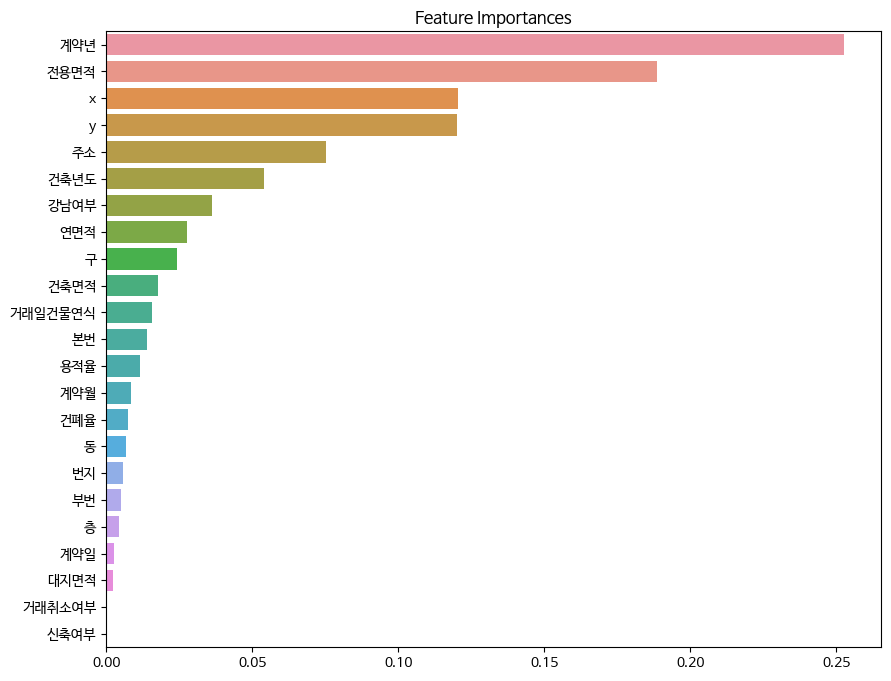

In [59]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [48]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [50]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
823047870.2609 ± 8900351.9650,계약년
536944566.6213 ± 7820460.5348,전용면적
503390054.3853 ± 908357.0511,강남여부
464525321.1065 ± 3725634.6999,구
220041093.3418 ± 1321259.2984,건축년도
164955812.8059 ± 3791409.1530,좌표X
81769146.1616 ± 812894.8077,동
77491296.2992 ± 1140328.2482,좌표Y
68289406.9442 ± 780157.3094,거래일건물연식
48265561.3721 ± 290119.0346,부번


- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [ ]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [ ]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [ ]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [ ]:
X_val_sort.head()

- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [ ]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [ ]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [ ]:
display(error_top100.head(1))
display(best_top100.head(1))

- 이제 분포를 비교해보도록 하겠습니다.

In [ ]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

In [ ]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [ ]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

In [ ]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

In [ ]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

## 7. Output File Save

In [ ]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)